In [31]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from pathlib import Path
from sklearn.preprocessing import LabelEncoder
import PIL
import cv2

In [33]:
image_dir = Path('E:\Lian\S2\Datasets\Braille Dataset\Braille Dataset')

In [34]:
dir_list = list(image_dir.glob('*.jpg'))

In [35]:
image_count = len(dir_list)
image_count

1560

In [36]:
name_list = []
for i in dir_list:
    name_list.append(os.path.basename(i)[0])

In [37]:
#opens images and puts into a list
images = []
for dir in dir_list:
    I = cv2.imread(str(dir))
    images.append(I)

In [38]:
#turn both lists in numpy arrays
images_list = np.array(images)
name_list = np.array(name_list).T #transpose - convert columns to rows

In [39]:
#encodes name_list and normalizes image_list
le = LabelEncoder()
name_list = le.fit_transform(name_list)

#covert image to 0 to 255 (pixel information)
images_list = images_list / 255.0 
print(images_list[0])

[[[0.76078431 0.76078431 0.76078431]
  [0.8        0.8        0.8       ]
  [0.80784314 0.80784314 0.80784314]
  ...
  [0.76862745 0.76862745 0.76862745]
  [0.76862745 0.76862745 0.76862745]
  [0.76862745 0.76862745 0.76862745]]

 [[0.75686275 0.75686275 0.75686275]
  [0.69411765 0.69411765 0.69411765]
  [0.7372549  0.7372549  0.7372549 ]
  ...
  [0.76862745 0.76862745 0.76862745]
  [0.76862745 0.76862745 0.76862745]
  [0.76862745 0.76862745 0.76862745]]

 [[0.78039216 0.78039216 0.78039216]
  [0.79607843 0.79607843 0.79607843]
  [0.76470588 0.76470588 0.76470588]
  ...
  [0.76862745 0.76862745 0.76862745]
  [0.76862745 0.76862745 0.76862745]
  [0.76862745 0.76862745 0.76862745]]

 ...

 [[0.76862745 0.76862745 0.76862745]
  [0.77254902 0.77254902 0.77254902]
  [0.76470588 0.76470588 0.76470588]
  ...
  [0.76862745 0.76862745 0.76862745]
  [0.76862745 0.76862745 0.76862745]
  [0.76862745 0.76862745 0.76862745]]

 [[0.77254902 0.77254902 0.77254902]
  [0.77647059 0.77647059 0.77647059]


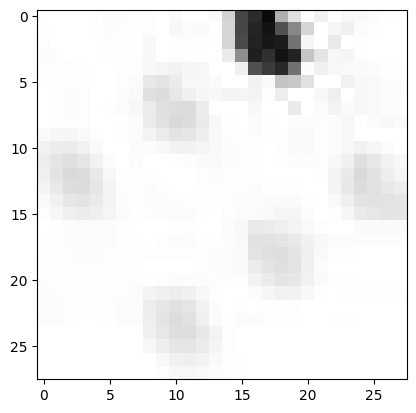

In [40]:
plt.imshow(images_list[1])

In [41]:
from sklearn.model_selection import train_test_split

In [42]:
X_train, X_test, y_train, y_test = train_test_split(images_list, name_list, test_size=0.2, random_state=42)
X_train = np.expand_dims(X_train, axis=-1) / 255.0
X_test = np.expand_dims(X_test, axis=-1) / 255.0

# Creating model: Trial 1: Adam Optimizer

In [43]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Define the GhostNet building blocks
def ghost_module(x, out_channels, ratio=2, dw_kernel_size=3, s=1):
    init_channels = int(np.ceil(out_channels / ratio))
    new_channels = init_channels * (ratio - 1)
    
    # Primary convolution
    primary_conv = layers.Conv2D(init_channels, kernel_size=1, strides=s, padding='same')(x)
    primary_conv = layers.BatchNormalization()(primary_conv)
    primary_conv = layers.ReLU()(primary_conv)
    
    # Depthwise convolution
    depthwise_conv = layers.DepthwiseConv2D(kernel_size=dw_kernel_size, strides=s, padding='same')(primary_conv)
    depthwise_conv = layers.BatchNormalization()(depthwise_conv)
    depthwise_conv = layers.ReLU()(depthwise_conv)
    
    # Ghost feature maps (pointwise conv to generate extra features)
    ghost_conv = layers.Conv2D(new_channels, kernel_size=1, strides=1, padding='same')(depthwise_conv)
    ghost_conv = layers.BatchNormalization()(ghost_conv)
    ghost_conv = layers.ReLU()(ghost_conv)
    
    # Concatenate primary and ghost
    out = layers.Concatenate()([primary_conv, ghost_conv])
    
    return out

def build_ghostnet(input_shape=(28, 28, 3), num_classes=576):
    inputs = layers.Input(shape=input_shape)
    
    # Initial stem layer
    x = layers.Conv2D(16, kernel_size=3, strides=1, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    
    # First ghost block
    x = ghost_module(x, out_channels=32)
    x = layers.MaxPooling2D(pool_size=2)(x)
    
    # Second ghost block
    x = ghost_module(x, out_channels=64)
    x = layers.MaxPooling2D(pool_size=2)(x)
    
    # Third ghost block
    x = ghost_module(x, out_channels=128)
    
    # Global average pooling and dense layer for classification
    x = layers.GlobalAveragePooling2D()(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    
    model = models.Model(inputs, outputs)

    return model

In [44]:
# Build the GhostNet model
model = build_ghostnet()
model.summary()  

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 28, 28, 3)]  0           []                               
                                                                                                  
 conv2d_7 (Conv2D)              (None, 28, 28, 16)   448         ['input_2[0][0]']                
                                                                                                  
 batch_normalization_10 (BatchN  (None, 28, 28, 16)  64          ['conv2d_7[0][0]']               
 ormalization)                                                                                    
                                                                                                  
 re_lu_10 (ReLU)                (None, 28, 28, 16)   0           ['batch_normalization_10[0]

In [45]:
model.compile(optimizer="Adam", loss="SparseCategoricalCrossentropy", metrics=["sparse_categorical_accuracy"])

In [46]:
from keras.callbacks import EarlyStopping

es1 = EarlyStopping(patience=20, monitor="val_sparse_categorical_accuracy", mode="auto")
es2 = EarlyStopping(patience=20, monitor="val_loss", mode="auto")

history = model.fit(
    x=X_train,
    y=y_train,
    epochs=100,
    validation_split=0.3,
    callbacks=[es1, es2]
)

Epoch 1/100
28/28 [==============================] - 4s 100ms/step - loss: 5.3338 - sparse_categorical_accuracy: 0.0447 - val_loss: 5.9140 - val_sparse_categorical_accuracy: 0.0453
Epoch 2/100
28/28 [==============================] - 1s 46ms/step - loss: 3.7020 - sparse_categorical_accuracy: 0.0871 - val_loss: 4.8516 - val_sparse_categorical_accuracy: 0.0320
Epoch 3/100
28/28 [==============================] - 1s 47ms/step - loss: 3.2356 - sparse_categorical_accuracy: 0.1501 - val_loss: 4.0737 - val_sparse_categorical_accuracy: 0.0427
Epoch 4/100
28/28 [==============================] - 1s 49ms/step - loss: 3.0450 - sparse_categorical_accuracy: 0.2085 - val_loss: 3.7309 - val_sparse_categorical_accuracy: 0.0427
Epoch 5/100
28/28 [==============================] - 1s 44ms/step - loss: 2.8792 - sparse_categorical_accuracy: 0.2188 - val_loss: 3.7346 - val_sparse_categorical_accuracy: 0.0427
Epoch 6/100
28/28 [==============================] - 1s 43ms/step - loss: 2.7034 - sparse_categoric

In [47]:
time = np.arange(1, len(history.history['loss'])+1)

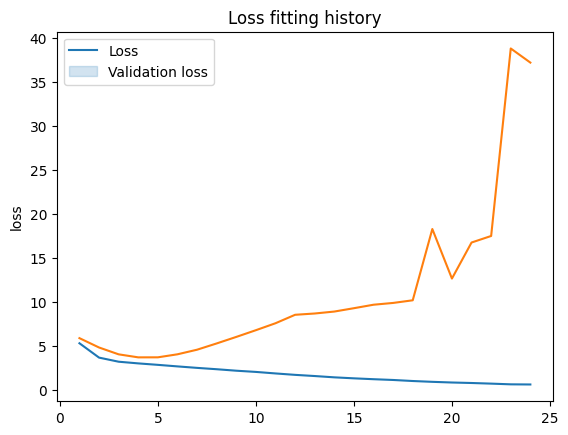

In [48]:
sns.lineplot(data=history.history, x=time, y='loss')
sns.lineplot(data=history.history, x=time, y='val_loss')
plt.title('Loss fitting history')
plt.legend(labels=['Loss', 'Validation loss'])
plt.show()

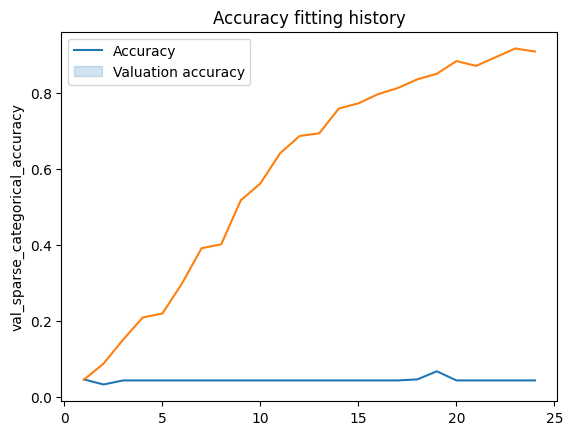

In [49]:
sns.lineplot(data=history.history, x=time, y='val_sparse_categorical_accuracy')
sns.lineplot(data=history.history, x=time, y='sparse_categorical_accuracy')
plt.title('Accuracy fitting history')
plt.legend(labels=['Accuracy', 'Valuation accuracy'])
plt.show()

In [50]:
print("Adam Optimizer")
model.evaluate(X_test, y_test)

Adam Optimizer
10/10 [==============================] - 0s 14ms/step - loss: 36.4600 - sparse_categorical_accuracy: 0.0449


[36.460044860839844, 0.044871795922517776]

# Optimization Model 1

In [51]:
!pip install --upgrade tensorflow-model-optimization

In [52]:
import tensorflow_model_optimization as tfmot

In [53]:
original_model = model

model_save_path = 'cnn_model1_braille.keras'

model.save(model_save_path)


# Get the size of the model in bytes

model_size = os.path.getsize(model_save_path)

print(f"Model size: {model_size / 1024:.2f} KB")

Model size: 1239.41 KB


In [54]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import tensorflow.keras as keras
import time

prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude

callbacks = [
  tfmot.sparsity.keras.UpdatePruningStep()
]
pruning_params = {
    'pruning_schedule': tfmot.sparsity.keras.ConstantSparsity(0.1, begin_step=0, frequency=100)
}

pruned_model = prune_low_magnitude(original_model, **pruning_params)

In [55]:
pruned_model.compile(optimizer="Adam", loss="SparseCategoricalCrossentropy", metrics=["sparse_categorical_accuracy"])
pruned_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 28, 28, 3)]  0           []                               
                                                                                                  
 prune_low_magnitude_conv2d_7 (  (None, 28, 28, 16)  882         ['input_2[0][0]']                
 PruneLowMagnitude)                                                                               
                                                                                                  
 prune_low_magnitude_batch_norm  (None, 28, 28, 16)  65          ['prune_low_magnitude_conv2d_7[0]
 alization_10 (PruneLowMagnitud                                  [0]']                            
 e)                                                                                         

# Pruning

In [56]:
import time

start_pruning_time = time.time()



# Train the model
history = pruned_model.fit(x=X_train,

                    y=y_train,

                    epochs=100,

                    validation_split=0.3,

                    callbacks=[es1, es2, tfmot.sparsity.keras.UpdatePruningStep()])



end_time = time.time()

total_time = end_time - start_pruning_time 

print(f"Total time: {total_time:.2f} seconds")

Epoch 1/100
28/28 [==============================] - 15s 70ms/step - loss: 0.6169 - sparse_categorical_accuracy: 0.9141 - val_loss: 70.3043 - val_sparse_categorical_accuracy: 0.0427
Epoch 2/100
28/28 [==============================] - 1s 41ms/step - loss: 0.5294 - sparse_categorical_accuracy: 0.9381 - val_loss: 63.4734 - val_sparse_categorical_accuracy: 0.0427
Epoch 3/100
28/28 [==============================] - 1s 46ms/step - loss: 0.4984 - sparse_categorical_accuracy: 0.9450 - val_loss: 123.4303 - val_sparse_categorical_accuracy: 0.0427
Epoch 4/100
28/28 [==============================] - 1s 42ms/step - loss: 0.4624 - sparse_categorical_accuracy: 0.9496 - val_loss: 111.5885 - val_sparse_categorical_accuracy: 0.0427
Epoch 5/100
28/28 [==============================] - 1s 48ms/step - loss: 0.4345 - sparse_categorical_accuracy: 0.9496 - val_loss: 77.1872 - val_sparse_categorical_accuracy: 0.0427
Epoch 6/100
28/28 [==============================] - 1s 40ms/step - loss: 0.3882 - sparse_ca

# Evaluate the model with testing data

In [57]:
# Evaluate the model on the test data
pruned_test_loss, pruned_test_acc = pruned_model.evaluate(X_test, y_test)
print(f"Test accuracy: {pruned_test_acc}")

10/10 [==============================] - 0s 10ms/step - loss: 111.2495 - sparse_categorical_accuracy: 0.0449
Test accuracy: 0.044871795922517776


In [58]:
model_save_path = 'cnn_pruned_model1_braille.keras'
pruned_model.save(model_save_path)

# Get the size of the model in bytes

model_size = os.path.getsize(model_save_path)

print(f"Model size after pruning: {model_size / 1024:.2f} KB")

Model size after pruning: 1658.33 KB


In [59]:
model_for_export = tfmot.sparsity.keras.strip_pruning(pruned_model)

converter = tf.lite.TFLiteConverter.from_keras_model(model_for_export)

tflite_model = converter.convert()



# Save the TFLite model to a file

model_save_path = 'pruned_model1_braille.tflite'

with open(model_save_path, 'wb') as f:

    f.write(tflite_model)



model_size = os.path.getsize(model_save_path)

print(f"Model size after pruning + convert to tf lite: {model_size / 1024:.2f} KB")

INFO:tensorflow:Assets written to: C:\Users\User\AppData\Local\Temp\tmpw1zgg7ee\assets


INFO:tensorflow:Assets written to: C:\Users\User\AppData\Local\Temp\tmpw1zgg7ee\assets


Model size after pruning + convert to tf lite: 349.07 KB


# Post Training Quantization

In [63]:
# Strip the pruning wrappers to finalize the pruned model
final_model = tfmot.sparsity.keras.strip_pruning(pruned_model)
final_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 28, 28, 3)]  0           []                               
                                                                                                  
 conv2d_7 (Conv2D)              (None, 28, 28, 16)   448         ['input_2[0][0]']                
                                                                                                  
 batch_normalization_10 (BatchN  (None, 28, 28, 16)  64          ['conv2d_7[2][0]']               
 ormalization)                                                                                    
                                                                                                  
 re_lu_10 (ReLU)                (None, 28, 28, 16)   0           ['batch_normalization_10[2]

In [64]:
# Convert to TensorFlow Lite model with quantization

converter = tf.lite.TFLiteConverter.from_keras_model(final_model)



# Set quantization parameters

converter.optimizations = [tf.lite.Optimize.DEFAULT]  # Default optimization includes quantization



# Optionally, if you have representative data, you can enable full integer quantization:

# Provide a representative dataset for better accuracy in quantization

def representative_dataset():

    for data in X_test.take(100):  # use a small sample of your data <<< what if we change this to 1000? to all data? 70rb? how?

        yield [tf.dtypes.cast(data, tf.float32)] # can we change this to integer?



converter.representative_dataset = representative_dataset

converter.target_spec.supported_types = [tf.float16]  # This can be int8 as well, hm... << nope, error



# Convert the model

quantized_tflite_model = converter.convert()



# Save the quantized model to a file

with open('quantized_pruned_model1_braille.tflite', 'wb') as f:

    f.write(quantized_tflite_model)



# To load and use the TFLite model later:

interpreter = tf.lite.Interpreter(model_path='quantized_pruned_model1_braille.tflite')

interpreter.allocate_tensors()

INFO:tensorflow:Assets written to: C:\Users\User\AppData\Local\Temp\tmpy1xa_ogj\assets


INFO:tensorflow:Assets written to: C:\Users\User\AppData\Local\Temp\tmpy1xa_ogj\assets


In [65]:
final_model.compile(optimizer="Adam", loss="SparseCategoricalCrossentropy", metrics=["sparse_categorical_accuracy"])

In [66]:
start_quantization_time = time.time()



history = final_model.fit(x=X_train,

                    y=y_train,

                    epochs=100,

                    validation_split=0.3,

                    callbacks=[es1, es2, tfmot.sparsity.keras.UpdatePruningStep()])



end_time = time.time()

total_time = end_time - start_quantization_time 

print(f"Total time: {total_time:.2f} seconds")

Epoch 1/100
28/28 [==============================] - 4s 59ms/step - loss: 0.0977 - sparse_categorical_accuracy: 0.9863 - val_loss: 69.3941 - val_sparse_categorical_accuracy: 0.0453
Epoch 2/100
28/28 [==============================] - 2s 61ms/step - loss: 0.0938 - sparse_categorical_accuracy: 0.9931 - val_loss: 39.6835 - val_sparse_categorical_accuracy: 0.0453
Epoch 3/100
28/28 [==============================] - 1s 37ms/step - loss: 0.0857 - sparse_categorical_accuracy: 0.9931 - val_loss: 30.1881 - val_sparse_categorical_accuracy: 0.0347
Epoch 4/100
28/28 [==============================] - 1s 39ms/step - loss: 0.0688 - sparse_categorical_accuracy: 0.9954 - val_loss: 52.6186 - val_sparse_categorical_accuracy: 0.0507
Epoch 5/100
28/28 [==============================] - 1s 38ms/step - loss: 0.0591 - sparse_categorical_accuracy: 0.9989 - val_loss: 56.1915 - val_sparse_categorical_accuracy: 0.0400
Epoch 6/100
28/28 [==============================] - 1s 37ms/step - loss: 0.0544 - sparse_categ

In [67]:
model_size = os.path.getsize('quantized_pruned_model1_braille.tflite')

print(f"Model size after quantization: {model_size / 1024:.2f} KB")

Model size after quantization: 184.26 KB


In [68]:
# Evaluate the model on the test data

final_test_loss, final_test_acc = final_model.evaluate(X_test, y_test)



print(f"Test accuracy: {final_test_acc}")

10/10 [==============================] - 0s 10ms/step - loss: 161.7095 - sparse_categorical_accuracy: 0.0449
Test accuracy: 0.044871795922517776
